In [ ]:
import sys

sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kgbuilder')

In [ ]:
!pip install rdflib
!pip install datashader

!pip install --upgrade networkx==2.6 scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59439 sha256=20f143ffb7a6a5ebc8b33446f19688e5682753dda9c45c86e89e4bad170d0dc5
  Stored in directory: /root/.cache/pip/wheels/6d/79/c4/c425774559165f472d32e5ef592ff9a71179abb31f05dbc98b
Successfully built datashape
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [ ]:
from rdflib import Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

import requests

import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle


from itertools import chain

import scipy

In [ ]:
from utils import *

In [ ]:
from visuals import *
from queries import *

In [ ]:
from networkx.algorithms import community


In [ ]:
def detect_communities(G, threshold=0.5):
    """Detect communities in a graph using the Girvan-Newman algorithm.
    
    Parameters
    ----------
    G : networkx.Graph
        The graph to be analyzed.
    threshold : float, optional
        The modularity threshold for detecting communities. The default value is 0.5.
        
    Returns
    -------
    list of lists
        A list of lists, where each inner list contains the nodes in a community.
    """
    # Use the Girvan-Newman algorithm to detect communities
    communities = list(community.girvan_newman(G))
    
    # Extract the communities from the partition
    communities = [c for c in communities if community.modularity(G, c) > threshold]
    
    return communities

In [ ]:
prune_policy={'remove_deadend':True, 'remove_isolated':True}
G=star_merging_pipeline(10, prune_policy)

[rdflib.term.URIRef('http://wikiba.se/ontology#NormalRank'), rdflib.term.Literal('WeRelate person ID', lang='en'), rdflib.term.URIRef('http://wikiba.se/ontology#Statement'), rdflib.term.Literal('Europeana entity', lang='en'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Thing'), rdflib.term.Literal('Grammy Awards artist ID', lang='en'), rdflib.term.Literal('KINENOTE person ID', lang='en'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Restriction'), rdflib.term.Literal('geni.com', lang='en'), rdflib.term.Literal('publisher', lang='en'), rdflib.term.URIRef('http://schema.org/Article'), rdflib.term.Literal('Larousse ID', lang='en'), rdflib.term.Literal('Oxford Dictionary of National Biography ID', lang='en'), rdflib.term.URIRef('http://wikiba.se/ontology#ExternalId'), rdflib.term.Literal('Encyclopædia Universalis ID', lang='en'), rdflib.term.Literal('husband', lang='en'), rdflib.term.Literal('Kinorium person ID', lang='en'), rdflib.term.Literal('LittleSis people ID', lang='en'),

In [ ]:
print(l)

MultiDiGraph with 7543 nodes and 16036 edges


In [ ]:
image=create_plot_graph_force_directed(G)

Force-directed

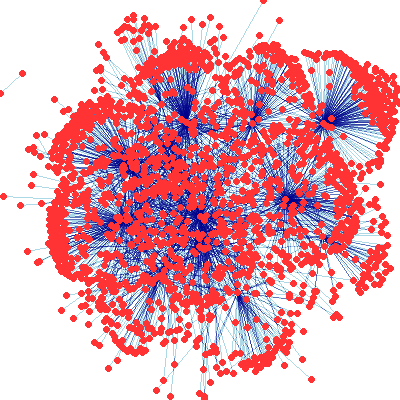

In [ ]:
tf.Images(image).cols(1)

In [ ]:
comm=detect_communities(G, threshold=0.5)
print(comm)

In [ ]:
from crawler import *

In [ ]:
def explore_selected(properties,n_incr,policy):
    prop_concat=""
    for p in properties:
      prop_concat+=" {?person ?property wd:"+p.split('/')[-1]+". } UNION"
    query='''SELECT DISTINCT ?person ?personLabel 
    WHERE {
    {
        ?person wdt:P31 wd:Q5 . #?personId is a human 
        '''+prop_concat+'''
    
        { 
            ?person wdt:P21 ?sexorgender. #?person has ?sexorgender
            #?sexorgender is not male, female, cisgender male, cigender female, or cisgender person
            FILTER(?sexorgender NOT IN (wd:Q6581097, wd:Q6581072, wd:Q15145778, wd:Q15145779, wd:Q1093205)). 
        } UNION {
            ?person wdt:P91 ?sexualorientation . #?person has ?sexualorientation
            FILTER(?sexualorientation != wd:Q1035954). #?sexualorientation is not heterosexual
        }
    }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }

    } LIMIT '''
    print(query)
    return star_merging_pipeline_print(n_incr, query, policy)

def crawler_process(G, n_iter, k_prop, n_incr, policy, n_max=None, people_list=[], alpha=0.85, pagerank_iter=100):
    for i in range(n_iter):
        pr = nx.pagerank(G, alpha=alpha, max_iter=pagerank_iter)

        sorted_nodes = [key for key,val in sorted(pr.items(),key=lambda ele:ele[1],reverse=True) if "entity/" in key]

        print(sorted_nodes[0:k_prop])
        #should add an if to check if prop one of the type of useful properties (not number or wikipedia etc)
        prop_graph,new_list=explore_selected(sorted_nodes[0:k_prop],n_incr,policy)
        people_list=list(set(people_list + new_list))
        G=nx.compose(G,prop_graph)
        if n_max!=None and len(people_list)>n_max:
            return G
    return G

In [ ]:
new_G=crawler_process(G, 2, 4, 5, prune_policy, n_max=10, people_list=l)

[rdflib.term.URIRef('http://www.wikidata.org/entity/Q23833686'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q36578'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q58284'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q6581097')]
SELECT DISTINCT ?person ?personLabel 
    WHERE {
    {
        ?person wdt:P31 wd:Q5 . #?personId is a human 
         {?person ?property wd:Q23833686. } UNION {?person ?property wd:Q36578. } UNION {?person ?property wd:Q58284. } UNION {?person ?property wd:Q6581097. } UNION
    
        { 
            ?person wdt:P21 ?sexorgender. #?person has ?sexorgender
            #?sexorgender is not male, female, cisgender male, cigender female, or cisgender person
            FILTER(?sexorgender NOT IN (wd:Q6581097, wd:Q6581072, wd:Q15145778, wd:Q15145779, wd:Q1093205)). 
        } UNION {
            ?person wdt:P91 ?sexualorientation . #?person has ?sexualorientation
            FILTER(?sexualorientation != wd:Q1035954). #?sexualorientation is no

KeyboardInterrupt: ignored

Force-directed

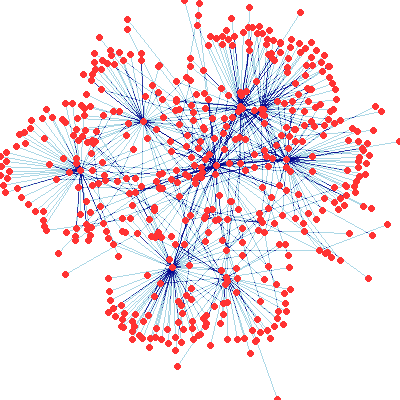

In [ ]:
image=create_plot_graph_force_directed(new_G)
tf.Images(image).cols(1)